## Environment Set-up

In [1]:
from pathlib import Path

import numpy as np
from PIL import Image
import pandas as pd
import pydicom
import matplotlib.pyplot as plt

import math
import torch

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    if False:
        torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

## Load Dataset

In [3]:
# DATA_DIR = Path("/kaggle/input/czii-cryoet-630x630-png-dataset-816bit")
IMG_DIR = Path("../../proc/yolo11_padding/datasets/czii_det2d/images/train")
BBOX_PATH = Path("../yolo11/df_labels_padding.csv")

MASKS_DIR = Path("../../proc/SAM/masks")

In [4]:
df = pd.read_csv(BBOX_PATH)
df = df.set_index(["exp_name", "frame"])
df = df.sort_index()

df.head()

x         y    height     width  label
exp_name frame                                               
TS_5_4   10     0.561035  0.297070  0.028125  0.028125      2
         10     0.803125  0.097418  0.040625  0.040625      4
         20     0.925042  0.809548  0.018750  0.018750      0
         20     0.561035  0.297070  0.028125  0.028125      2
         20     0.803125  0.097418  0.040625  0.040625      4

## End-to-end batched inference

In [5]:
from sam2.sam2_image_predictor import SAM2ImagePredictor

predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2.1-hiera-large", device=device)

/workspace/CZII/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def get_img_path(exp_name, frame, IMG_DIR, type):
    img_path = IMG_DIR / f"{exp_name}_{frame}.png"
    return img_path

def load_img(img_path):
    image = Image.open(img_path)
    image = np.array(image.convert("RGB"), dtype=np.float32)
    image /= 255.
    return image
    

# https://github.com/facebookresearch/syegment-anything-2/blob/main/notebooks/image_predictor_example.ipynb
def xyhw_to_xyxy(box, H=640, W=640):
    xmin = ((box[:, 0] - box[:, 2]/2) * H).astype(int)
    ymin = ((box[:, 1] - box[:, 3]/2) * W).astype(int)
    xmax = ((box[:, 0] + box[:, 2]/2) * H).astype(int)
    ymax = ((box[:, 1] + box[:, 3]/2) * W).astype(int)
    return np.stack([xmin, ymin, xmax, ymax], axis=-1)
    
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax, edgecolor='green'):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=edgecolor, facecolor=(0, 0, 0, 0), lw=2))   

# Utils to get and save mask
def get_mask_to_save(masks, labels):
    h, w = masks.shape[-2:]
    output_mask = np.zeros((h,w), dtype=np.uint8)
    # loop over all labels and merge them
    for label in np.unique(labels):
        mask = np.any(masks[labels == label, ...], axis=0)[0]
        output_mask[mask] = label

    return output_mask

def save_mask(mask, mask_path):
    mask_path.parent.mkdir(parents=True, exist_ok=True)
    mask = Image.fromarray(mask)
    mask.save(mask_path)

In [7]:
generated_masks = {}

for (exp_name, frame), chunk in df.groupby(level=[0, 1]):
    if exp_name == "TS_5_4":
        continue
    
    img_path = get_img_path(exp_name, frame, IMG_DIR, type="images")
    img = load_img(img_path)
    H, W, _ = img.shape
    
    input_boxes = chunk.values[:, :4]
    input_boxes = xyhw_to_xyxy(input_boxes, H, W)

    # SAM Set image and predict
    predictor.set_image(img)
    
    masks, scores, _ = predictor.predict(
        box=input_boxes,
        multimask_output=False,
    )

#     # Store all masks in generated_masks
    generated_masks[exp_name] = generated_masks.get(exp_name, {})
    generated_masks[exp_name][frame] = masks.astype(np.uint8)
    # generated_masks[exp_name][frame] = 0

#     # Save masks
    labels = chunk.values[:, 4]
    output_mask = get_mask_to_save(masks, labels) 

    mask_path = get_img_path(exp_name, frame, MASKS_DIR, type="masks")
    save_mask(output_mask, mask_path)

## Score Generated Masks

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse_all = {}
mae_all = {}
for (exp_name, frame), chunk in df.groupby(level=[0, 1]):
    if exp_name == "TS_5_4":
        continue

    # get masks and labels
    masks = generated_masks[exp_name][frame]
    bboxes = chunk.values[:, :4]
    labels = chunk.values[:, 4]

    xc_preds, yc_preds = [], []
    for i, mask in enumerate(masks):
        if not mask.any():
            xc_preds.append(0)
            yc_preds.append(0)
            continue

        # Calculate xc, yc of the preds
        rows, cols = np.where(mask.squeeze() != 0)
        xmin, xmax = np.min(cols), np.max(cols)
        ymin, ymax = np.min(rows), np.max(rows)
        
        xc_pred, yc_pred = (xmin + xmax) / 2, (ymin + ymax) / 2
        xc_true, yc_true = bboxes[i][0] * H, bboxes[i][1] * W
        h, w = bboxes[i][2] * H, bboxes[i][3] * W

        xc_preds.append(xc_pred)
        yc_preds.append(yc_pred)

    # Calculate regression metrics
    for label in np.unique((labels)):
        mse = mean_squared_error(bboxes[:, 0][labels == label] * H, np.array(xc_preds)[labels == label]) \
                + mean_squared_error(bboxes[:, 1][labels == label] * W, np.array(yc_preds)[labels == label])
        mae = mean_absolute_error(bboxes[:, 0][labels == label] * H, np.array(xc_preds)[labels == label]) \
                + mean_absolute_error(bboxes[:, 1][labels == label] * W, np.array(yc_preds)[labels == label])

        # Append label wise scores
        mse_all[label] = mse_all.get(label, []) + [mse]
        mae_all[label] = mae_all.get(label, []) + [mae]

In [9]:
print("#"*4, "Observed errors between the target and generated Coordinates.")

pd.DataFrame(
    {
        "label": mse_all.keys(),
        "mae": [sum(e) / len(e) / 640 for _, e in mae_all.items()],
        "mse": [sum(e) / len(e) / 640**2 for _, e in mse_all.items()],
    },
).sort_values('label').set_index('label')

#### Observed errors between the target and generated Coordinates.


mae       mse
label                    
0.0    0.002089  0.000146
2.0    0.003189  0.000076
3.0    0.003692  0.000012
4.0    0.006014  0.000573
5.0    0.001896  0.000004

## Visualizations

In [10]:
dict_colors = {
    0: "red",
    1: "blue",
    2: "green",
    3: "yellow",
    4: "purple",
    5: "orange",
}
# p2i_dict = {
#         'apo-ferritin': 0,
#         'beta-amylase': 1,
#         'beta-galactosidase': 2,
#         'ribosome': 3,
#         'thyroglobulin': 4,
#         'virus-like-particle': 5
#     }

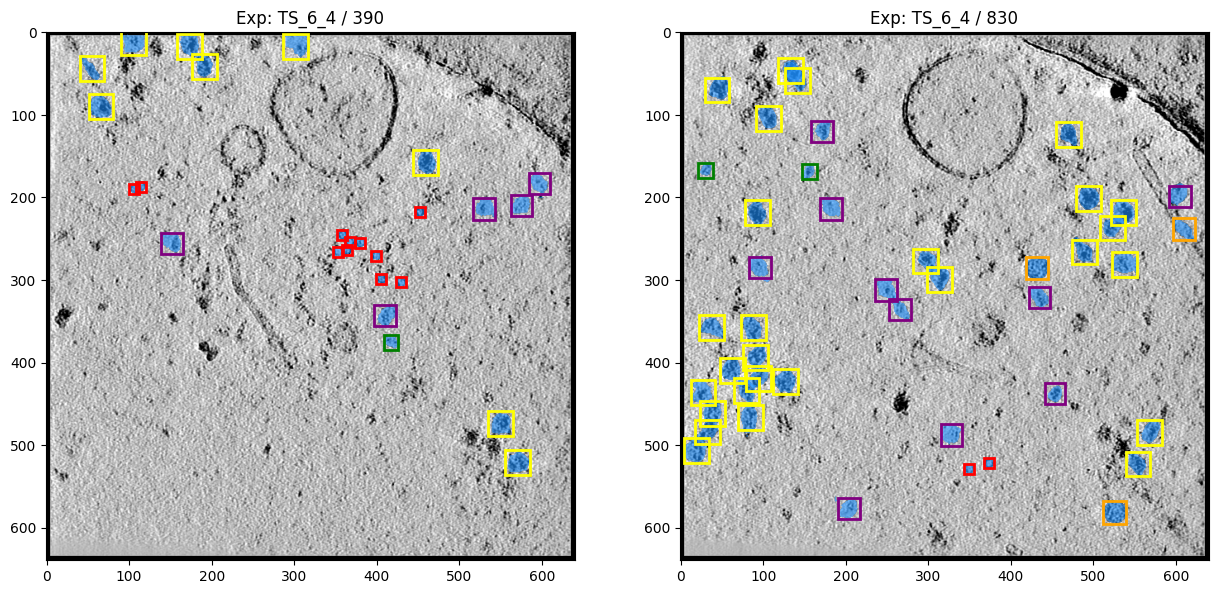

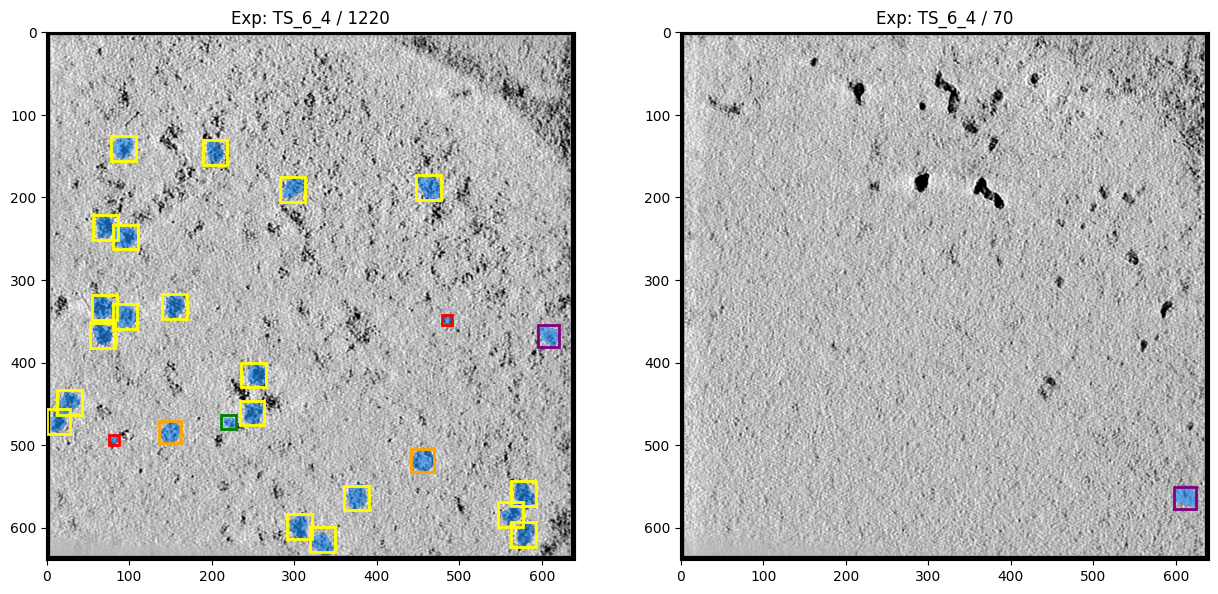

In [11]:
EXP_NAME = "TS_6_4"
EXP_MASKS = generated_masks[EXP_NAME]

# Rnadomly show 6 frames
frames = np.random.choice(list(EXP_MASKS.keys()), size=6)
for j in range(2): 
    # Create a plt figure
    plt.figure(figsize=(15, 10))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        frame = frames[j*2 + i]
        plt.title(f'Exp: {EXP_NAME} / {frame}')
        # Show image
        img = load_img(get_img_path(EXP_NAME, frame, IMG_DIR, type="images"))
        plt.imshow(img)
        # Show mask
        masks = EXP_MASKS[frame]
        for mask in masks:
            show_mask(mask.squeeze(), plt.gca())
        # Show bbox
        boxes = xyhw_to_xyxy(df.loc[(EXP_NAME, frame)].values[:, :4])
        labels = df.loc[(EXP_NAME, frame)].values[:, 4]
        for box, label in zip(boxes, labels):
            show_box(box, plt.gca(), edgecolor=dict_colors[label])

plt.show()

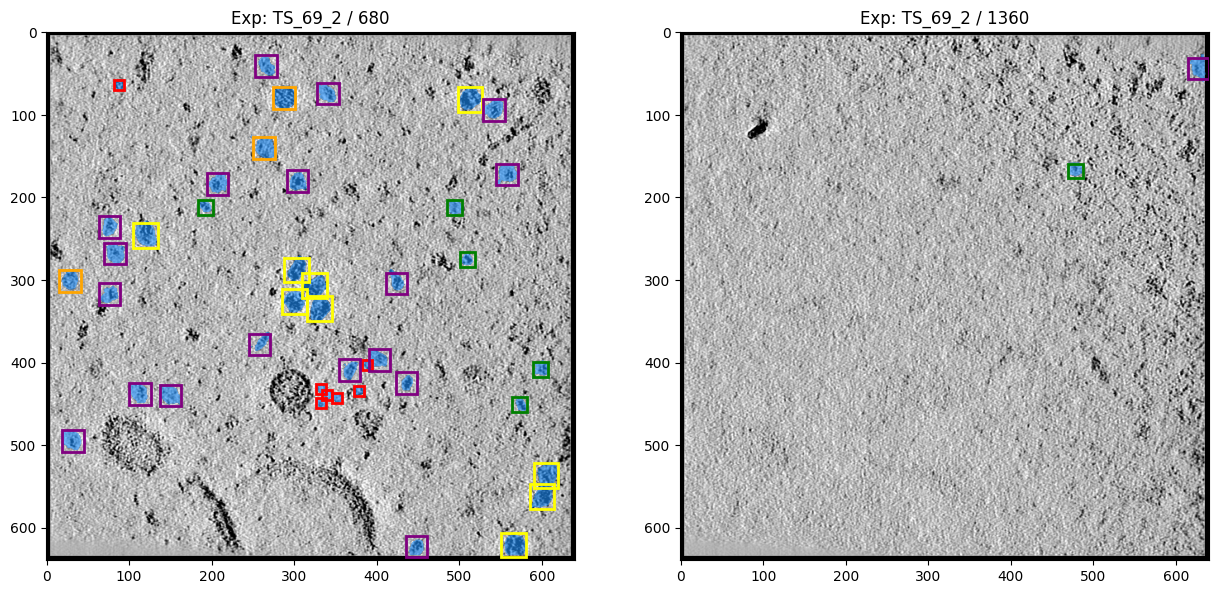

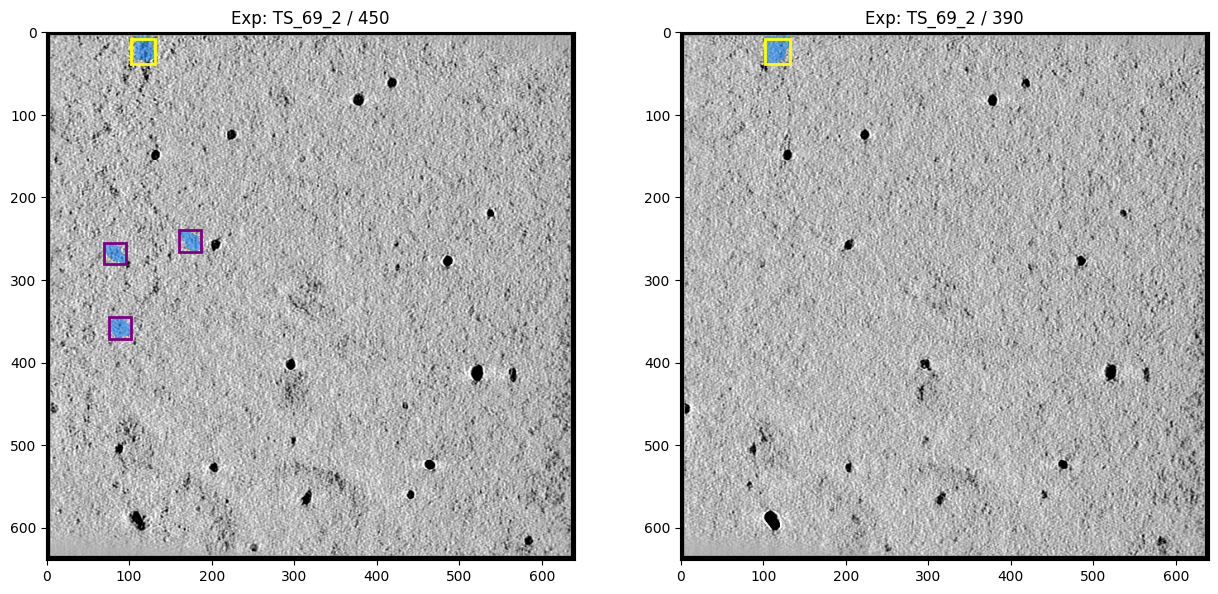

In [12]:
EXP_NAME = "TS_69_2"
EXP_MASKS = generated_masks[EXP_NAME]

# Rnadomly show 6 frames
frames = np.random.choice(list(EXP_MASKS.keys()), size=6)
for j in range(2): 
    # Create a plt figure
    plt.figure(figsize=(15, 10))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        frame = frames[j*2 + i]
        plt.title(f'Exp: {EXP_NAME} / {frame}')
        # Show image
        img = load_img(get_img_path(EXP_NAME, frame, IMG_DIR, type="images"))
        plt.imshow(img)
        # Show mask
        masks = EXP_MASKS[frame]
        for mask in masks:
            show_mask(mask.squeeze(), plt.gca())
        # Show bbox
        boxes = xyhw_to_xyxy(df.loc[(EXP_NAME, frame)].values[:, :4])
        labels = df.loc[(EXP_NAME, frame)].values[:, 4]
        for box, label in zip(boxes, labels):
            show_box(box, plt.gca(), edgecolor=dict_colors[label])

plt.show()

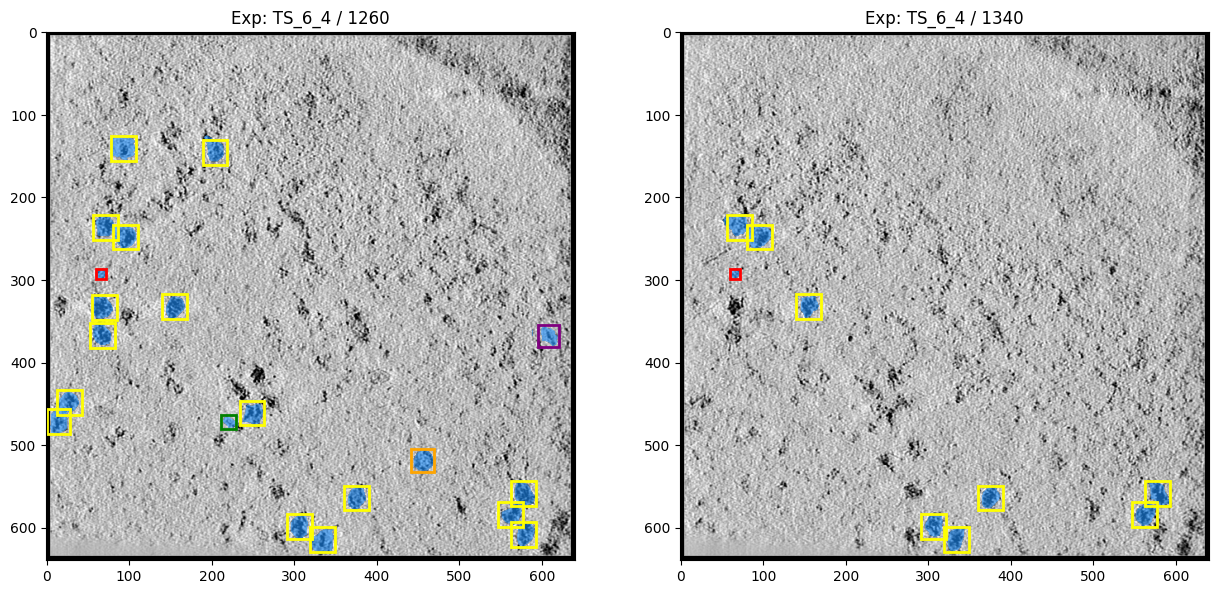

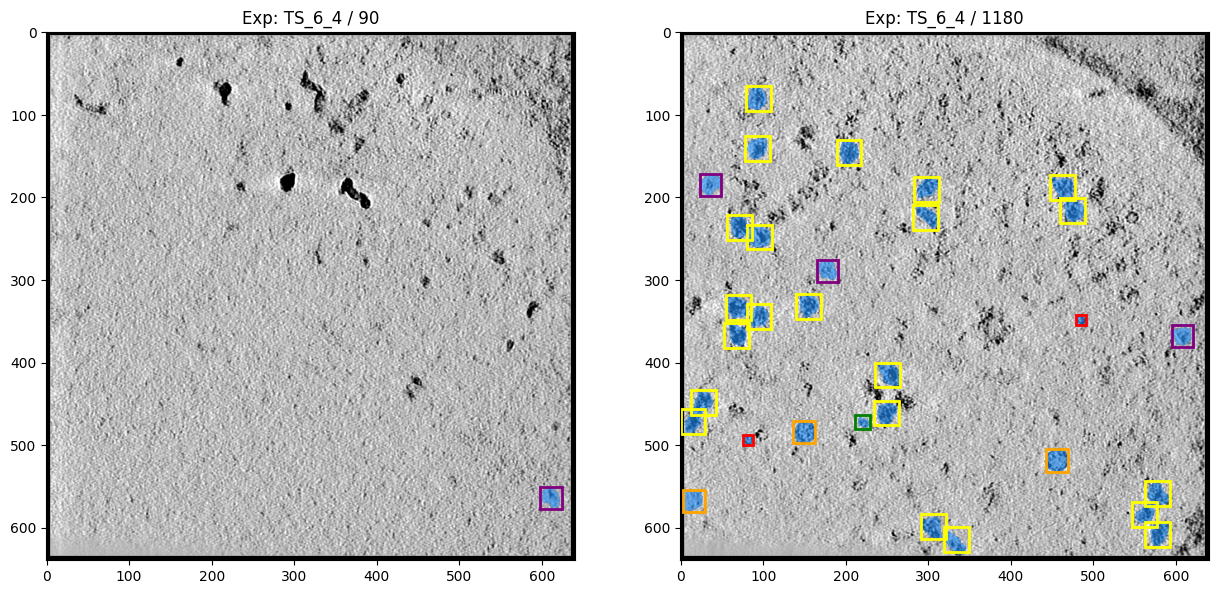

In [13]:
EXP_NAME = "TS_6_4"
EXP_MASKS = generated_masks[EXP_NAME]

# Rnadomly show 6 frames
frames = np.random.choice(list(EXP_MASKS.keys()), size=6)
for j in range(2): 
    # Create a plt figure
    plt.figure(figsize=(15, 10))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        frame = frames[j*2 + i]
        plt.title(f'Exp: {EXP_NAME} / {frame}')
        # Show image
        img = load_img(get_img_path(EXP_NAME, frame, IMG_DIR, type="images"))
        plt.imshow(img)
        # Show mask
        masks = EXP_MASKS[frame]
        for mask in masks:
            show_mask(mask.squeeze(), plt.gca())
        # Show bbox
        boxes = xyhw_to_xyxy(df.loc[(EXP_NAME, frame)].values[:, :4])
        labels = df.loc[(EXP_NAME, frame)].values[:, 4]
        for box, label in zip(boxes, labels):
            show_box(box, plt.gca(), edgecolor=dict_colors[label])

plt.show()

In [14]:
# EXP_NAME = "TS_6_6"
# EXP_MASKS = generated_masks[EXP_NAME]

# # Rnadomly show 6 frames
# frames = np.random.choice(list(EXP_MASKS.keys()), size=6)
# for j in range(3): 
#     # Create a plt figure
#     plt.figure(figsize=(15, 10))
#     for i in range(2):
#         plt.subplot(1, 2, i+1)
#         frame = frames[j*2 + i]
#         plt.title(f'Exp: {EXP_NAME} / {frame}')
#         # Show image
#         img = load_img(get_img_path(EXP_NAME, frame, IMG_DIR, type="images"))
#         plt.imshow(img)
#         # Show mask
#         # masks = EXP_MASKS[frame]
#         # for mask in masks:
#         #     show_mask(mask.squeeze(), plt.gca())
#         # Show bbox
#         boxes = xyhw_to_xyxy(df.loc[(EXP_NAME, frame)].values[:, :4])
#         labels = df.loc[(EXP_NAME, frame)].values[:, 4]
#         for box, label in zip(boxes, labels):
#             show_box(box, plt.gca(), edgecolor=dict_colors[label])

# plt.show()

In [15]:
# EXP_NAME = "TS_86_3"
# EXP_MASKS = generated_masks[EXP_NAME]

# # Rnadomly show 6 frames
# frames = np.random.choice(list(EXP_MASKS.keys()), size=6)
# for j in range(3): 
#     # Create a plt figure
#     plt.figure(figsize=(15, 10))
#     for i in range(2):
#         plt.subplot(1, 2, i+1)
#         frame = frames[j*2 + i]
#         plt.title(f'Exp: {EXP_NAME} / {frame}')
#         # Show image
#         img = load_img(get_img_path(EXP_NAME, frame, IMG_DIR, type="images"))
#         plt.imshow(img)
#         # Show mask
#         masks = EXP_MASKS[frame]
#         for mask in masks:
#             show_mask(mask.squeeze(), plt.gca())
#         # Show bbox
#         boxes = xyhw_to_xyxy(df.loc[(EXP_NAME, frame)].values[:, :4])
#         for box in boxes:
#             show_box(box, plt.gca())

# plt.show()

In [16]:
# EXP_NAME = "TS_99_9"
# EXP_MASKS = generated_masks[EXP_NAME]

# # Rnadomly show 6 frames
# frames = np.random.choice(list(EXP_MASKS.keys()), size=6)
# for j in range(3): 
#     # Create a plt figure
#     plt.figure(figsize=(15, 10))
#     for i in range(2):
#         plt.subplot(1, 2, i+1)
#         frame = frames[j*2 + i]
#         plt.title(f'Exp: {EXP_NAME} / {frame}')
#         # Show image
#         img = load_img(get_img_path(EXP_NAME, frame, IMG_DIR, type="images"))
#         plt.imshow(img)
#         # Show mask
#         masks = EXP_MASKS[frame]
#         for mask in masks:
#             show_mask(mask.squeeze(), plt.gca())
#         # Show bbox
#         boxes = xyhw_to_xyxy(df.loc[(EXP_NAME, frame)].values[:, :4])
#         for box in boxes:
#             show_box(box, plt.gca())

# plt.show()